# Item Prediction Using Graph Neoronal Networks

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random
import torch
import tqdm


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from db.graph import Neo4JConnector

In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)  # Set to your preferred seed value

In [3]:
random_state = 4201312
neo4j = Neo4JConnector.create_from_config("../config.ini")

In [4]:
name_encodings = set()
node_name_encodings_map = {}
node_type_map = {}
numer_node_types = {"Player": 10}
number_nodes = 10  # number players in a match

def create_encodings(node_type):
    res = neo4j.exec(f"MATCH (x:{node_type}) RETURN x")
    
    for r in res[0]:
        element_id = r["x"].element_id
        name = r["x"]["name"]
        name = f"{node_type}_{name}"
        name_encodings.add(name) # (element_id, node_type, name)
        node_name_encodings_map[element_id] = name
        node_type_map[element_id] = node_type
        numer_node_types[node_type] = 1 if node_type not in numer_node_types else numer_node_types[node_type] + 1 
        
for nt in ["Champion", "Role", "Lane"]:
    create_encodings(nt)
    number_nodes += numer_node_types[nt]

In [5]:
node_encodings = {x: 10 + i for i, x in enumerate(name_encodings)}
node_encodings_rev = {node_encodings[x]: x for x in node_encodings}
node_type_encodings = {x: i for i,x in enumerate(numer_node_types)}
node_type_encodings_rev = {node_type_encodings[x]: x for x in node_type_encodings}
node_name_encodings_map_rev = {node_name_encodings_map[x]: x for x in node_name_encodings_map}

In [6]:
def get_matches(limit = None):
    matches_query = """MATCH (m:Match) 
        WHERE m.gameType = "MATCHED_GAME" AND m.gameMode = "CLASSIC" AND 
            apoc.date.parse(toString(m.gameDuration), 's', 'HH:mm:ssX') > 1800
        RETURN m"""
    
    if limit is not None:
        matches_query = matches_query + " LIMIT " + str(limit)
        
    return np.array([x["m"]["matchID"] for x in neo4j.exec(matches_query)[0]])

matches = get_matches()

In [7]:
def encode_match(match_id):
    match_query = """MATCH (m: Match {matchID: $matchid})-[co:CONSISTS_OF]->(q:Queue)<-[pi:PLAYS_IN]-(p:PlayerInMatch)-[x]->(y: (Champion | Role | Lane)) RETURN q, p, x, y"""
    result = neo4j.exec(match_query, matchid=match_id)
    
    nodes_matrix = np.zeros((number_nodes, len(numer_node_types)), dtype=np.float64)
    adj_matrix = np.zeros((number_nodes, number_nodes), dtype=np.float64)
    result_vector = np.zeros(number_nodes, dtype=np.float64)
    
    result_set = False
    player_encodings = {}
    num_player = 0
    for x in result[0]:
        player_id = x["p"].element_id
        target_id = x["y"].element_id
        
        if player_id not in player_encodings:
            player_encodings[player_id] = num_player
            num_player = num_player + 1
        
        player_encoding = player_encodings[player_id]
        object_name = node_name_encodings_map[target_id]
        object_type = node_type_map[target_id]
        object_type_encoding = node_type_encodings[object_type]
        object_encoding = node_encodings[object_name]
        
        nodes_matrix[player_encoding, node_type_encodings["Player"]] = 1
        nodes_matrix[object_encoding, object_type_encoding] = 1
        
        if not result_set and object_type == "Champion":
            result_set = True
            result_vector[object_encoding] = 1
        else:
            adj_matrix[player_encoding, object_encoding] = 1
    
    nodes_matrix = torch.tensor(nodes_matrix).type(torch.float32)
    adj_matrix = torch.tensor(adj_matrix).type(torch.float64)
    result_vector = torch.tensor(result_vector).type(torch.float32)
    edge_index = adj_matrix.squeeze(0).nonzero().t().contiguous()
    
    return nodes_matrix, adj_matrix, result_vector, edge_index

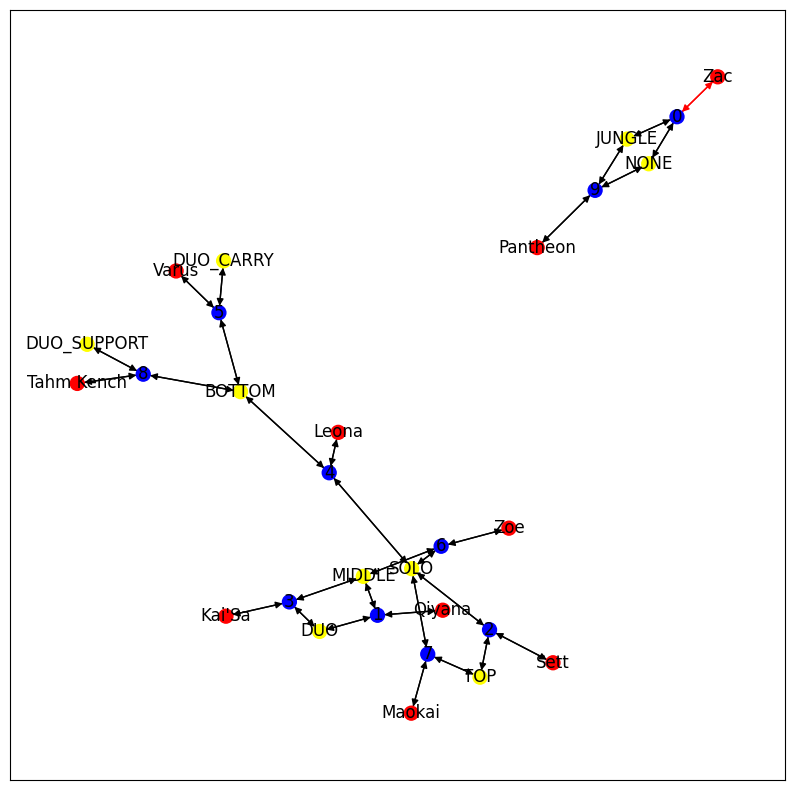

In [8]:
def plot_graph(adj_matrix, target_items):
    g = nx.from_numpy_matrix(adj_matrix)
    
    for edge in g.edges():
        g.edges[edge]["color"] = "black" 
    
    for node in g.nodes:
        if node < 10:
            g.nodes[node]["name"] = node
            g.nodes[node]["color"] = "blue"
        else:
            node_type_name = node_encodings_rev[node].split("_")
            node_type, node_name = node_type_name[0], "_".join(node_type_name[1:])
            g.nodes[node]["name"] = node_name
            if node_type == "Champion":
                g.nodes[node]["color"] = "red"
            elif node_type == "Item":
                g.nodes[node]["color"] = "green"
            else:
                g.nodes[node]["color"] = "yellow"

            
    for predict_item in np.where(target_items)[0]:
        g.add_edge(0, predict_item, color="red")
    
    g.remove_nodes_from(list(nx.isolates(g)))
    g = g.to_directed()
    
    pos = nx.spring_layout(g)
    node_names = {x: g.nodes[x]["name"] for x in g.nodes}
    node_colors = [g.nodes[x]["color"] for x in g.nodes]
    edge_colors = [g[u][v]['color'] for u,v in  g.edges()]
    
    fig, ax = plt.subplots(figsize=(10, 10))
    nx.draw_networkx(g, pos=pos, node_size=100, with_labels=True, labels=node_names, node_color=node_colors, edge_color=edge_colors, ax=ax)
    plt.savefig("../img/input_network.png")
    plt.show()
    
encoded_match = encode_match(matches[1])
plot_graph(encoded_match[1].numpy(), encoded_match[2].numpy())

In [9]:
#matches_test_validation, matches_train = train_test_split(matches, train_size=0.2, random_state=random_state)
#matches_test, matches_validation = train_test_split(matches_test_validation, train_size=0.5, random_state=random_state)
matches_train = matches[0:1000]
matches_validation = matches[1000:1200]
matches_test = matches[1200:]


matches_train = [encode_match(match) for match in tqdm.tqdm(matches_train)]
matches_test = [encode_match(match) for match in tqdm.tqdm(matches_test)]
matches_validation = [encode_match(match) for match in tqdm.tqdm(matches_validation)]

print(f"Train: {len(matches_train)}, Test: {len(matches_test)}, Validation: {len(matches_validation)}")

100%|██████████| 200/200 [00:01<00:00, 121.50it/s]

Train: 1000, Test: 21836, Validation: 200


In [10]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.fc(x)
        return F.log_softmax(x, dim=1).sum(dim=1)

model = GCN(4, 200, number_nodes)
model

GCN(
  (conv1): GCNConv(4, 200)
  (conv2): GCNConv(200, 200)
  (fc): Linear(in_features=200, out_features=187, bias=True)
)

In [11]:
if torch.cuda.is_available():
    model = model.cuda()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

save_path = "models/"
train_losses = []
validation_losses = []

def train(epochs = 100, early_stopping_limit=5):
    best_model = None
    best_val_loss = np.inf
    early_stopping = 0
    
    for epoch in range(epochs):
        print(f"", end = "")
        if early_stopping == early_stopping_limit:
            print(f"Early stopping...")
            break
            
        model.train()
        train_loss = 0.0
        
        losses_epoch = []
        for i, (nodes, adj_matrix, result_vector, edge_index) in enumerate(matches_train):
            print(f"\rTraining epoch {epoch}: {float(i) / float(len(matches_train))}", end="")
            optimizer.zero_grad()
            
            if torch.cuda.is_available():
                nodes, edge_index, result_vector = nodes.cuda(), edge_index.cuda(), result_vector.cuda()
            
            out = model(nodes, edge_index)
            
            loss = criterion(out, result_vector)
            losses_epoch.append(loss.item())
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
        train_loss /= len(matches_train)
        train_losses.append(train_loss)
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for i, (nodes, adj_matrix, result_vector, edge_index) in enumerate(matches_validation):
                print(f"\rValidating epoch {epoch}: {float(i) / float(len(matches_validation))}", end="")
                    
                if torch.cuda.is_available():
                    nodes, edge_index, result_vector = nodes.cuda(), edge_index.cuda(), result_vector.cuda()
                
                out = model(nodes, edge_index)
                
                loss = criterion(out, result_vector)
                val_loss += loss.item() 
                
            val_loss /= len(matches_validation)
            validation_losses.append(val_loss)
        
        early_stopping += 1
            
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = f"model_champ_{epoch}.pt"
            torch.save(model.state_dict(), save_path + best_model)
            early_stopping = 0
        
        print(f"Done: Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
        
    return best_model
    
model_file = train()

Validating epoch 0: 0.995Done: Training Loss: 15.9766, Validation Loss: 0.0866
Validating epoch 1: 0.995Done: Training Loss: 1.2058, Validation Loss: 0.0866
Validating epoch 2: 0.995Done: Training Loss: 0.2572, Validation Loss: 0.0866
Validating epoch 3: 0.995Done: Training Loss: 0.6962, Validation Loss: 0.0882
Validating epoch 4: 0.995Done: Training Loss: 1.2467, Validation Loss: 0.1339
Validating epoch 5: 0.995Done: Training Loss: 1.5171, Validation Loss: 0.0873
Early stopping...


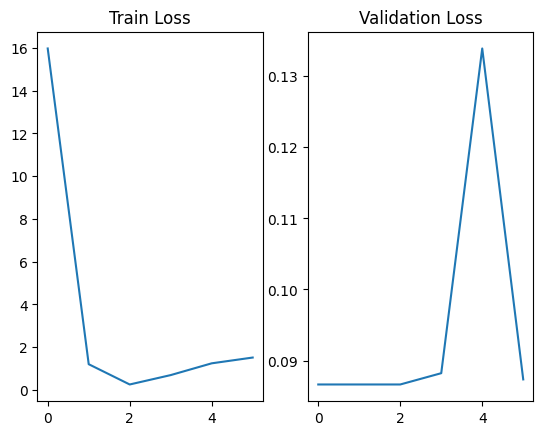

In [12]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(train_losses)
ax2.plot(validation_losses)
ax1.title.set_text('Train Loss')
ax2.title.set_text('Validation Loss')
plt.show()

In [13]:
model = GCN(4, 200, number_nodes)
model.load_state_dict(torch.load(save_path + "model_champ_1.pt"))
if torch.cuda.is_available():
    model = model.cuda()

In [14]:
def evaluation():
    model.eval()
    y,y_hat = [], []
    for nodes, adj_matrix, result_vector, edge_index in matches_test:
        if torch.cuda.is_available():
            nodes, edge_index, result_vector = nodes.cuda(), edge_index.cuda(), result_vector.cuda()
        
        y.append(node_encodings_rev[result_vector.cpu().detach().numpy().argmax()])
        
        results = model(nodes, edge_index)
        results = results.squeeze()
        y_hat.append(node_encodings_rev[results.cpu().detach().numpy().argmax()])
        
    
    return y, y_hat

res_y, res_y_hat = evaluation()
print(classification_report(res_y, res_y_hat))

                         precision    recall  f1-score   support

        Champion_Aatrox       1.00      1.00      1.00       296
          Champion_Ahri       1.00      0.99      0.99        86
         Champion_Akali       0.94      1.00      0.97       189
       Champion_Alistar       0.92      1.00      0.96        58
         Champion_Amumu       1.00      0.92      0.96        26
        Champion_Anivia       1.00      1.00      1.00        50
         Champion_Annie       1.00      1.00      1.00        26
      Champion_Aphelios       1.00      0.99      1.00       406
          Champion_Ashe       1.00      0.98      0.99       165
  Champion_Aurelion Sol       0.94      1.00      0.97        44
          Champion_Azir       1.00      1.00      1.00        57
          Champion_Bard       1.00      0.99      1.00       285
    Champion_Blitzcrank       1.00      0.99      0.99       293
         Champion_Brand       1.00      1.00      1.00        16
         Champion_Braum 

In [15]:
for a in zip(res_y, res_y_hat):
    print(a)

('Champion_Morgana', 'Champion_Morgana')
('Champion_Kalista', 'Champion_Kalista')
('Champion_Ezreal', 'Champion_Ezreal')
('Champion_Yasuo', 'Champion_Yasuo')
('Champion_LeBlanc', 'Champion_LeBlanc')
('Champion_Camille', 'Champion_Camille')
('Champion_Ekko', 'Champion_Ekko')
("Champion_Kai'Sa", "Champion_Kai'Sa")
('Champion_Olaf', 'Champion_Olaf')
('Champion_Leona', 'Champion_Leona')
('Champion_Leona', 'Champion_Leona')
('Champion_Lucian', 'Champion_Lucian')
('Champion_Sett', 'Champion_Sett')
('Champion_Senna', 'Champion_Senna')
('Champion_Yuumi', 'Champion_Yuumi')
('Champion_Lee Sin', 'Champion_Lee Sin')
('Champion_Gragas', 'Champion_Gragas')
('Champion_Aatrox', 'Champion_Aatrox')
('Champion_Kindred', 'Champion_Kindred')
('Champion_Gragas', 'Champion_Gragas')
('Champion_Braum', 'Champion_Braum')
('Champion_Karthus', 'Champion_Karthus')
('Champion_Olaf', 'Champion_Olaf')
('Champion_Orianna', 'Champion_Orianna')
('Champion_Jax', 'Champion_Jax')
('Champion_Ezreal', 'Champion_Ezreal')
('Ch